# Importing Data

In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def fa(r,c,size):
    fig, ax = plt.subplots(r,c,figsize=size)
    return fig, ax

In [121]:
data = r'D:\other studies\Quantium Case Comp 2024\QuantiumCaseComp2024\Risky Lending Data Set - revised.xlsx'

customers = pd.read_excel(data, sheet_name="Customers",header=5, usecols=range(1,8))
applications = pd.read_excel(data, sheet_name="Applications",header=5, usecols=range(1,10))
campaigns = pd.read_excel(data, sheet_name="Campaigns",header=5, usecols=range(1,8))
clawbacks= pd.read_excel(data, sheet_name="Clawbacks",header=5, usecols=range(1,5))

# DATES ARE YEAR-MONTH-DAY

# Descriptive analysis
## Revenue measurement
Measure revenue by getting summing loan amounts from applications sheet that do not have a clawback within 12 months (keep track of the account ID).
- Track clawbacks, check which ones closed the account within 1 year (difference between open date and close date should be less than 1 year or 365/366 days depending on leap or non-leap year).
- Remove the corresponding rows from the applications column by matching Account IDs.
- Sum the remaining loan values and multiply by 4% to get revenue for risky lending. Can do this by year also for comparison of revenue over the 3 years.
- Calculate potential revenue lost due to the clawbacks (track the Account IDs we removed) and multiply 4% by the corresponding loan amounts to get the amount that was lost.

### Measuring total revenue from applications
First calculating 4% of loan value for each application then summing to find total revenue

<Axes: ylabel='Loan Amount'>

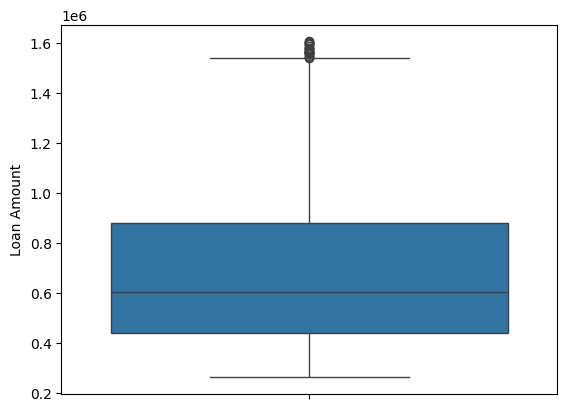

In [122]:
#checking for outliers and possible errors
sns.boxplot(data = applications['Loan Amount'])

<Axes: xlabel='Loan Amount', ylabel='Count'>

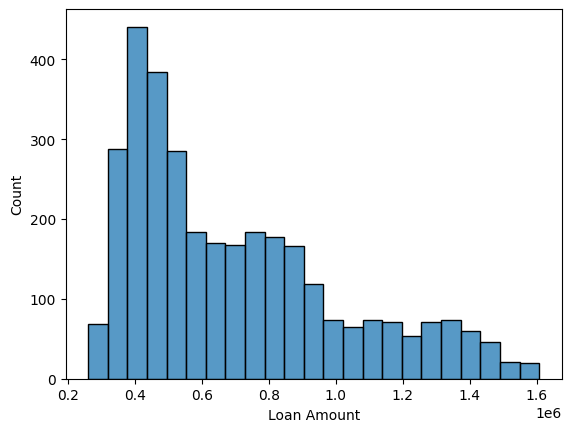

In [123]:
sns.histplot(data = applications['Loan Amount'])

In [124]:
total_revenue_from_applications = round(applications['Loan Amount'].sum()*0.04,2)
print('Total revenue from applications: $', total_revenue_from_applications)

Total revenue from applications: $ 91076973.44


In [125]:
#calculating revenue by year
yearly_revenue = {}
for year in [2020,2021,2022]:
    yearly_applications = applications[(applications['Application Date']<=pd.to_datetime(f'{year}/12/31'))*(applications['Application Date']>pd.to_datetime(f'{year-1}/12/31'))]
    yearly_revenue[year] = round(sum(yearly_applications['Loan Amount']*0.04),2)
    print('Application commission in year',year,' was $',yearly_revenue[year])
print('in total: $', sum(list(yearly_revenue.values())))

Application commission in year 2020  was $ 15026363.18
Application commission in year 2021  was $ 50552646.12
Application commission in year 2022  was $ 25497964.14
in total: $ 91076973.44


### Measuring loss from clawbacks
getting applications clawbacked, i.e closed within 1 year

In [126]:
clawbacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account ID          376 non-null    int64         
 1   Account Open Date   376 non-null    datetime64[ns]
 2   Account Close Date  376 non-null    datetime64[ns]
 3   Close Reason        376 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 11.9+ KB


In [127]:
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason
0,10040,2020-07-09,2021-01-29,REFINANCE
1,10230,2020-09-20,2020-12-10,REFINANCE
2,10393,2020-12-10,2021-04-16,DEFAULT
3,10331,2020-11-16,2021-05-20,REFINANCE
4,10326,2020-11-07,2021-03-15,DEFAULT
...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE
372,11961,2022-01-18,2022-04-20,REFINANCE
373,12343,2022-04-08,2022-05-20,REFINANCE
374,12334,2022-04-12,2022-06-04,DEFAULT


In [128]:
clawbacks['open date + 12 mths'] = clawbacks['Account Open Date']+ pd.DateOffset(months=12)
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason,open date + 12 mths
0,10040,2020-07-09,2021-01-29,REFINANCE,2021-07-09
1,10230,2020-09-20,2020-12-10,REFINANCE,2021-09-20
2,10393,2020-12-10,2021-04-16,DEFAULT,2021-12-10
3,10331,2020-11-16,2021-05-20,REFINANCE,2021-11-16
4,10326,2020-11-07,2021-03-15,DEFAULT,2021-11-07
...,...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE,2023-01-08
372,11961,2022-01-18,2022-04-20,REFINANCE,2023-01-18
373,12343,2022-04-08,2022-05-20,REFINANCE,2023-04-08
374,12334,2022-04-12,2022-06-04,DEFAULT,2023-04-12


In [129]:
sum(clawbacks['Account Close Date']<clawbacks['open date + 12 mths'])

376

All are closed within 12 mths

In [130]:
clawbacked_bool_array = applications["Account ID"].isin(clawbacks["Account ID"])
clawbacked_applications = applications[clawbacked_bool_array]
len(clawbacked_applications)

376

In [131]:
total_loss_from_clawbacks = round(clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
print('Total loss from clawbacked: $', total_loss_from_clawbacks)

Total loss from clawbacked: $ 10827669.69


In [132]:
#finding yearly clawbacked loss
yearly_clawbacked_losses = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks[(clawbacks['Account Close Date']<= pd.to_datetime(f'{year}/12/31'))*(clawbacks['Account Close Date']> pd.to_datetime(f'{year-1}/12/31'))]
    yearly_clawbacked_bool_array= applications["Account ID"].isin(yearly_clawbacks["Account ID"])
    yearly_clawbacked_applications = applications[yearly_clawbacked_bool_array]
    yearly_loss_from_clawbacks = round(yearly_clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
    yearly_clawbacked_losses[year] = yearly_loss_from_clawbacks
    print('Yearly loss from clawbacked: $', yearly_loss_from_clawbacks)
print('in total: $', sum(list(yearly_clawbacked_losses.values())))

Yearly loss from clawbacked: $ 696265.26
Yearly loss from clawbacked: $ 6074415.93
Yearly loss from clawbacked: $ 4056988.5
in total: $ 10827669.69


### Revenue - clawback loss:

In [133]:
print('Revenue - clawback loss: $',total_revenue_from_applications-total_loss_from_clawbacks)

Revenue - clawback loss: $ 80249303.75


In [134]:
#yearly revenue - clawback loss
for year in [2020,2021,2022]:
    print(f'revenue - loss for year {year}: $', yearly_revenue[year]-yearly_clawbacked_losses[year])


revenue - loss for year 2020: $ 14330097.92
revenue - loss for year 2021: $ 44478230.19
revenue - loss for year 2022: $ 21440975.64


# Investigating application opening amounts
- by month
- clawbacks by month (when they actually occur)

In [135]:
#splitting applications by year, then grouping by month and finding no. of applications per month
applications['Account Open Date'] = applications['Application Date'] + pd.DateOffset(weeks=3)
monthly_applications_size = {}
for year in [2020,2021,2022]:
    yearly_applications = applications.loc[(pd.to_datetime(f"{year-1}/12/31")<applications['Account Open Date'])*(applications['Account Open Date']<= pd.to_datetime(f"{year}/12/31"))]
    yearly_applications = yearly_applications.groupby(yearly_applications['Account Open Date'].dt.month)
    yearly_applications = yearly_applications.size()
    yearly_applications = pd.DataFrame(yearly_applications)
    yearly_applications['year'] = year
    monthly_applications_size[year] = yearly_applications

In [136]:
#concatenating all years tgt and preparing to plot
no_of_applications_by_month = pd.concat([monthly_applications_size[year] for year in [2020,2021,2022]])
no_of_applications_by_month['Month'] = np.arange(len(no_of_applications_by_month))
no_of_applications_by_month.rename(columns={0:'No. of Accounts opened'},inplace=True)
no_of_applications_by_month

no_of_applications_by_month

,No. of Accounts opened,year,Month
Account Open Date,,,
7,47,2020,0
8,96,2020,1
9,98,2020,2
10,81,2020,3
11,88,2020,4
12,97,2020,5
1,87,2021,6
2,82,2021,7
3,96,2021,8


<Axes: xlabel='Month', ylabel='No. of Accounts opened'>

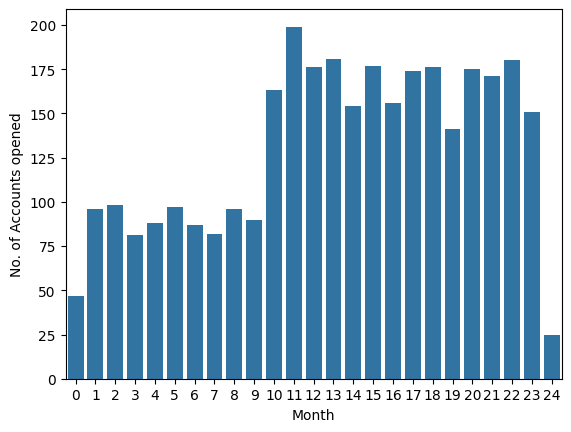

In [137]:
#plotting chart of account opening counts by month
sns.barplot(data=no_of_applications_by_month, x="Month", y = "No. of Accounts opened")

- Repeating for clawbacks (closure dates)

In [138]:
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason,open date + 12 mths
0,10040,2020-07-09,2021-01-29,REFINANCE,2021-07-09
1,10230,2020-09-20,2020-12-10,REFINANCE,2021-09-20
2,10393,2020-12-10,2021-04-16,DEFAULT,2021-12-10
3,10331,2020-11-16,2021-05-20,REFINANCE,2021-11-16
4,10326,2020-11-07,2021-03-15,DEFAULT,2021-11-07
...,...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE,2023-01-08
372,11961,2022-01-18,2022-04-20,REFINANCE,2023-01-18
373,12343,2022-04-08,2022-05-20,REFINANCE,2023-04-08
374,12334,2022-04-12,2022-06-04,DEFAULT,2023-04-12


In [139]:
#splitting applications by year, then grouping by month and finding no. of applications per month
account_closure_monthly_size = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks.loc[(pd.to_datetime(f"{year-1}/12/31")<clawbacks['Account Close Date'])*(clawbacks['Account Close Date']<= pd.to_datetime(f"{year}/12/31"))]
    yearly_clawbacks = yearly_clawbacks.groupby(yearly_clawbacks['Account Close Date'].dt.month)
    yearly_clawbacks = yearly_clawbacks.size()
    yearly_clawbacks = pd.DataFrame(yearly_clawbacks)
    yearly_clawbacks['year'] = year
    account_closure_monthly_size[year] = yearly_clawbacks

#concatenating all years tgt and preparing to plot
no_of_clawbacks_by_month = pd.concat([account_closure_monthly_size[year] for year in [2020,2021,2022]])
no_of_clawbacks_by_month['Month'] = np.arange(len(no_of_clawbacks_by_month))
no_of_clawbacks_by_month.rename(columns={0:'No. of Accounts Closed'},inplace=True)
no_of_clawbacks_by_month

,No. of Accounts Closed,year,Month
Account Close Date,,,
7,1,2020,0
8,3,2020,1
9,3,2020,2
10,8,2020,3
11,4,2020,4
12,6,2020,5
1,7,2021,6
2,10,2021,7
3,6,2021,8


<Axes: xlabel='Month', ylabel='No. of Accounts Closed'>

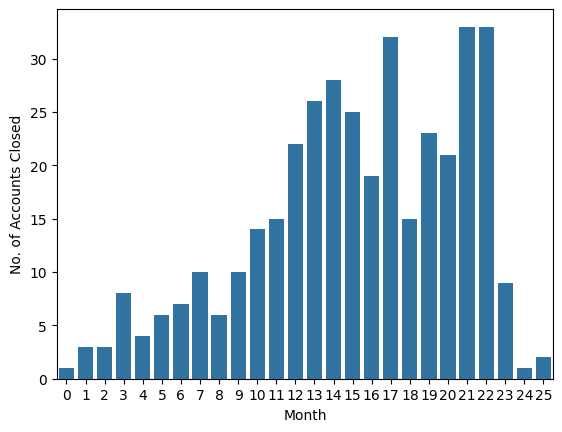

In [140]:
sns.barplot(data=no_of_clawbacks_by_month,x = 'Month', y="No. of Accounts Closed")

In [141]:
#plotting them together

In [142]:
accounts_opening_and_closing_by_month = pd.concat([no_of_applications_by_month['No. of Accounts opened'].reset_index().drop(columns={'Account Open Date'}), no_of_clawbacks_by_month['No. of Accounts Closed'].reset_index().drop(columns={'Account Close Date'})], axis= 1)
accounts_opening_and_closing_by_month.index.names = ['Month']
accounts_opening_and_closing_by_month = accounts_opening_and_closing_by_month.reset_index()
accounts_opening_and_closing_by_month

,Month,No. of Accounts opened,No. of Accounts Closed
0,0,47.0,1
1,1,96.0,3
2,2,98.0,3
3,3,81.0,8
4,4,88.0,4
5,5,97.0,6
6,6,87.0,7
7,7,82.0,10
8,8,96.0,6
9,9,90.0,10


<Axes: xlabel='Month', ylabel='value'>

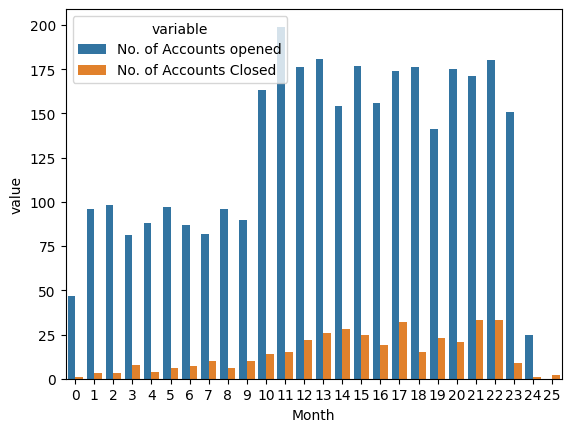

In [143]:
sns.barplot(data=accounts_opening_and_closing_by_month.melt(id_vars= 'Month'),x = 'Month', y = 'value', hue='variable') # need long format for hue parameter

Month 24 = June, Month 25 = sep

In [144]:
sorted_clawbacks = clawbacks.sort_values("Account Close Date")
sorted_clawbacks.tail()

,Account ID,Account Open Date,Account Close Date,Close Reason,open date + 12 mths
145,11871,2021-12-12,2022-06-20,REFINANCE,2022-12-12
143,12064,2021-12-12,2022-06-21,REFINANCE,2022-12-12
146,11865,2021-12-01,2022-07-08,REFINANCE,2022-12-01
147,12151,2022-02-09,2022-09-11,REFINANCE,2023-02-09
144,12246,2022-02-18,2022-09-17,REFINANCE,2023-02-18


In [145]:
applications

,Application ID,Application Date,Customer ID,Loan Amount,Home Value,Annual Income,Interest Rate (p.a.),Term (months),Account ID,Account Open Date
0,14088,2022-06-18,45307,1315392.00,1661798.4,122237,0.0399,40,13251,2022-07-09
1,14076,2022-06-18,45102,524727.18,708042.0,189335,0.0389,25,13241,2022-07-09
2,14096,2022-06-18,45238,1344389.00,1905753.0,144193,0.0395,30,13258,2022-07-09
3,14082,2022-06-17,45239,773627.94,867008.0,158661,0.0407,15,13245,2022-07-08
4,14080,2022-06-17,45227,1315458.00,1725310.8,137892,0.0379,40,13243,2022-07-08
...,...,...,...,...,...,...,...,...,...,...
3256,10013,2020-06-16,35169,1025966.48,1457603.0,159032,0.0375,30,10010,2020-07-07
3257,10010,2020-06-14,35152,1048110.00,1382829.0,122408,0.0394,30,10008,2020-07-05
3258,10005,2020-06-11,35104,510090.02,621030.9,58440,0.0440,40,10004,2020-07-02
3259,10003,2020-06-11,35013,407680.00,687440.0,72500,0.0397,25,10002,2020-07-02


# snip off all data points from 23 month onwards 

In [146]:
sorted_applications = applications.sort_values("Account Open Date")
sorted_applications.tail(15)

,Application ID,Application Date,Customer ID,Loan Amount,Home Value,Annual Income,Interest Rate (p.a.),Term (months),Account ID,Account Open Date
14,14081,2022-06-11,45231,807839.80,867300.0,196519,0.0473,30,13244,2022-07-02
13,14036,2022-06-13,45067,447580.00,591973.2,208096,0.0435,15,13211,2022-07-04
12,14067,2022-06-13,45323,311273.60,394828.0,225161,0.0460,25,13232,2022-07-04
10,14093,2022-06-14,45137,1259368.00,1787100.0,137540,0.0404,30,13255,2022-07-05
11,14091,2022-06-14,44872,807755.40,871470.0,156494,0.0424,30,13253,2022-07-05
9,14092,2022-06-15,45021,304220.00,430360.0,219319,0.0452,15,13254,2022-07-06
8,14041,2022-06-16,45093,337398.00,603709.0,250398,0.0431,25,13216,2022-07-07
7,14037,2022-06-16,45217,761265.54,832356.0,198959,0.0475,25,13212,2022-07-07
6,14071,2022-06-16,45123,756150.00,932940.0,150779,0.0421,30,13236,2022-07-07
5,14094,2022-06-17,45144,598842.00,749943.0,165113,0.0408,15,13256,2022-07-08


In [147]:
applications[applications['Account Open Date'] == pd.to_datetime("2020/6/20")]

,Application ID,Application Date,Customer ID,Loan Amount,Home Value,Annual Income,Interest Rate (p.a.),Term (months),Account ID,Account Open Date


# Creating a master df

In [148]:
sum(applications['Customer ID'].duplicated())

0

No customer has multiple applications

In [149]:
#adding customers and applications data together
df = pd.merge(customers, applications, on='Customer ID')
#adding campaign they signed up with
df = pd.merge(df, campaigns, on="Campaign ID", how='outer')
#adding clawbacks data
df['Clawbacked'] = df['Account ID'].isin(clawbacks['Account ID'])
df = pd.merge(df, clawbacks, on='Account ID', how='outer')

In [150]:
#getting rid of NaN values
df = df.fillna(0)

In [151]:
df.columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q  Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths'],
      dtype='object')

In [152]:
df.rename(columns={'Q  Factor 1': 'Q Factor 1'}, inplace=True)

# Checking relationship between Q factors and no. of clawbacks

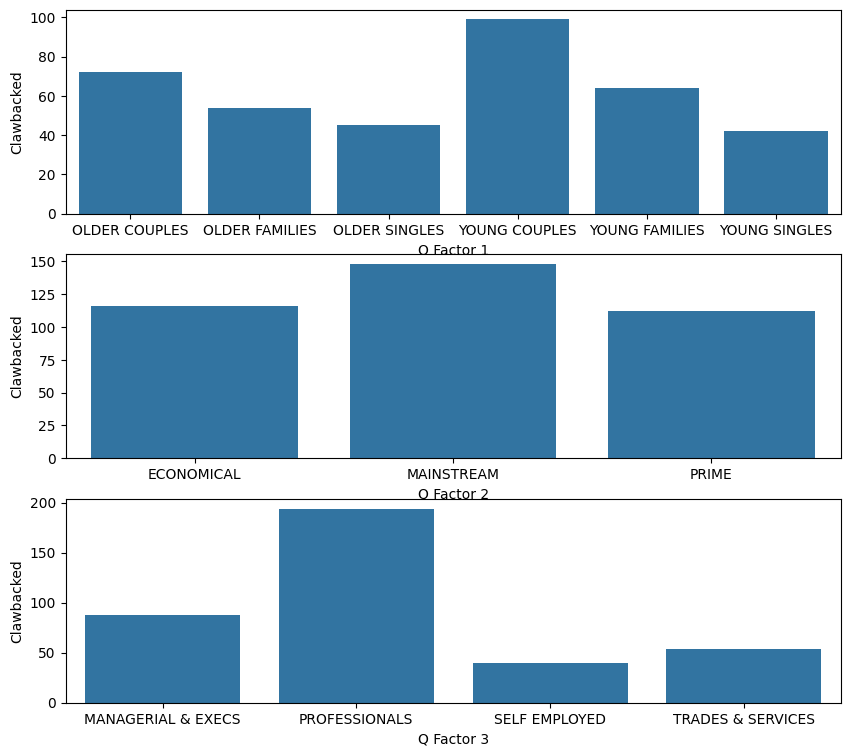

In [248]:
fig, ax = plt.subplots(3,1, figsize = (10,9))
for i in [1,2,3]:
    data = df.groupby(f'Q Factor {i}')['Clawbacked'].sum().reset_index()
    sns.barplot(data, ax = ax[i-1], x= f"Q Factor {i}", y = 'Clawbacked')

## Relationship between clawbacks and combination of (incl Q factor)
- Cumulative frequency graph

In [154]:
df['Clawbacked'] = df['Clawbacked'].astype(int)

In [155]:
df[['Loan Amount', 'Clawbacked', 'Q Factor 1']]

,Loan Amount,Clawbacked,Q Factor 1
0,687344.00,0,OLDER COUPLES
1,407680.00,0,YOUNG SINGLES
2,755609.24,1,YOUNG FAMILIES
3,510090.02,1,YOUNG SINGLES
4,888404.88,0,YOUNG COUPLES
...,...,...,...
3256,310837.17,0,OLDER FAMILIES
3257,1344389.00,0,YOUNG COUPLES
3258,1422840.00,0,YOUNG COUPLES
3259,386413.20,0,OLDER FAMILIES


In [195]:
# Function to plot cumulative frequency of clawbacks
def cumfreq_graph(x, variable, ax = False):
    '''Plots the cumulative frequency of the clawbacks with respect to `x` differentiated between `variable`'''
    cumfreq_df = df[[x, 'Clawbacked', variable]].sort_values(x)
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(variable)['Clawbacked'].cumsum()
    g = sns.lineplot(cumfreq_df, x = x, y = 'Cumulative Frequency', hue=variable)
    if ax:
        g = sns.lineplot(cumfreq_df, x = x, y = 'Cumulative Frequency', hue=variable,ax = ax)
    return g

<Axes: xlabel='Loan Amount', ylabel='Cumulative Frequency'>

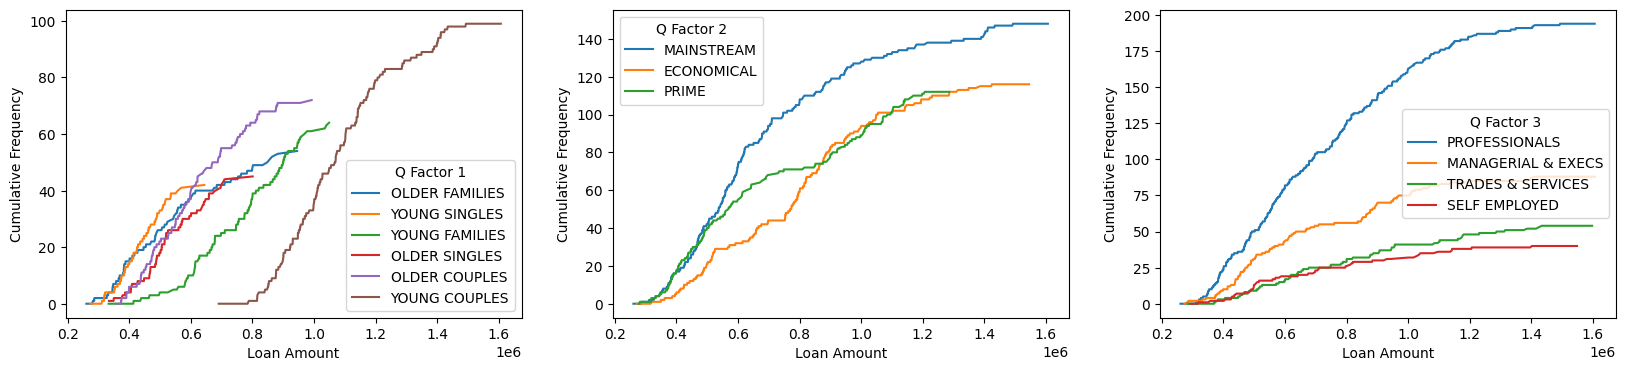

In [157]:
#plotting cumulative frequency of clawbacks to loan amounts, differentiating by Q factors

fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Loan Amount', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Loan Amount')
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    fig = sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency', hue=f'Q Factor {i+1}', ax = ax[i])
fig

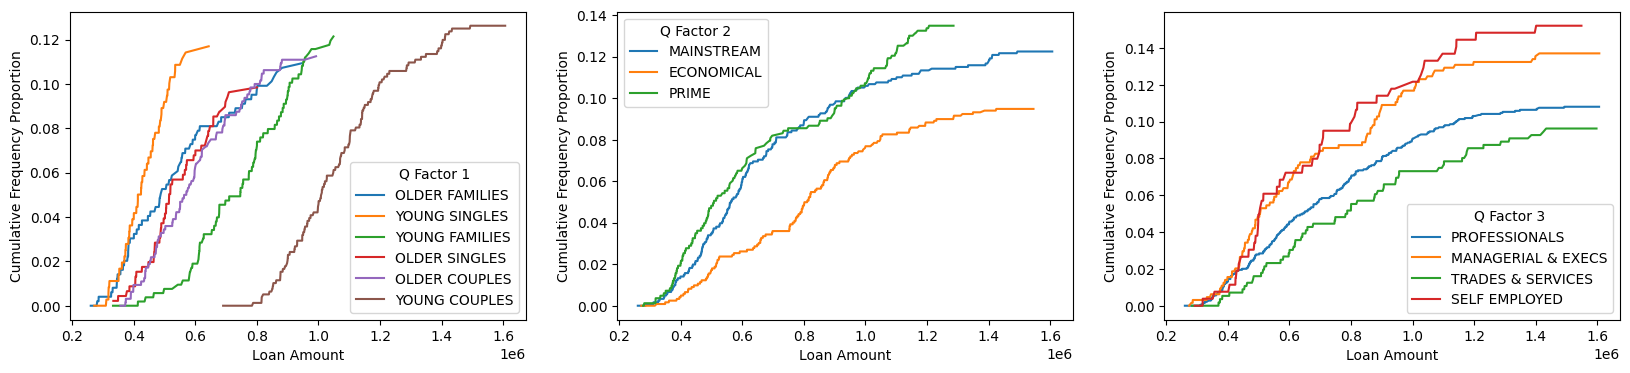

In [241]:
#plotting cumulative frequency of clawbacks as a proportion to loan amounts, differentiating by Q factors (STANDARDISING FOR UNEQUAL LOAN APPLICATION COUNTS) 
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    cumfreq_df = df[['Loan Amount', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Loan Amount')
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency Proportion'].astype('float64')
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])

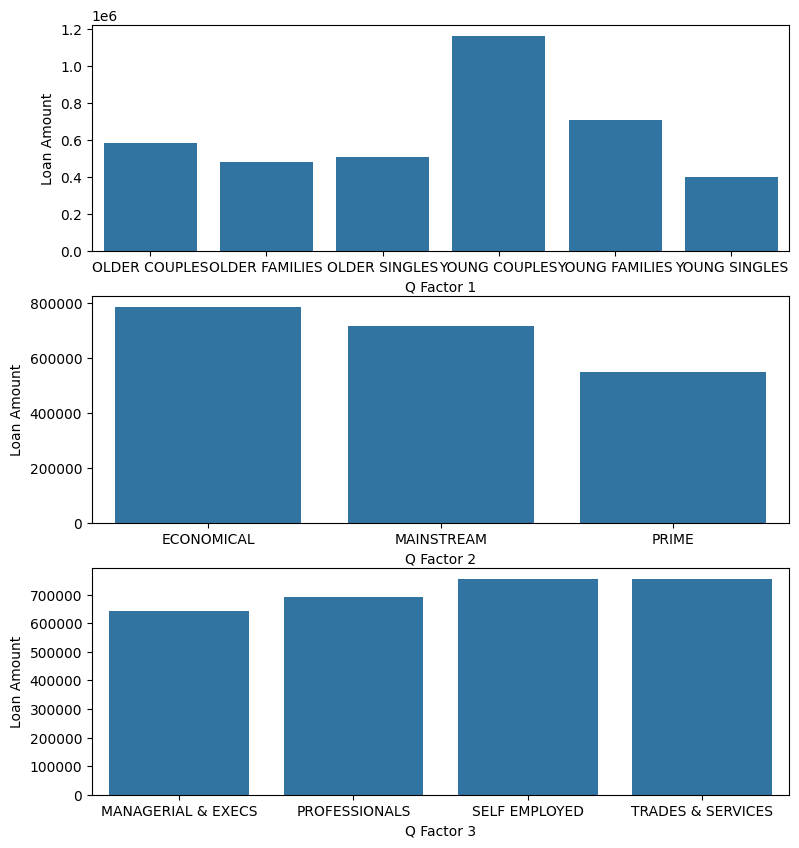

In [246]:
# Finding average loan amounts by Q factors
fig, ax = fa(3,1,(9,10))
for i in range(3):
    df.groupby(f'Q Factor {i+1}')['Loan Amount'].mean()
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Loan Amount'].mean(),ax=ax[i])

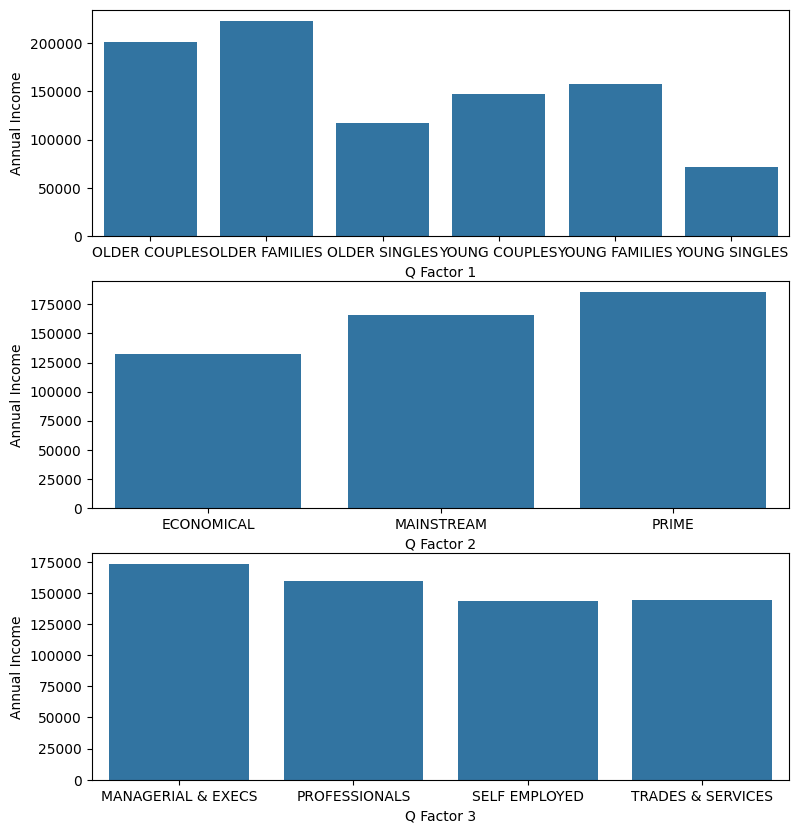

In [245]:
# Finding average annual income according to Q factors
fig, ax = fa(3,1,(9,10))
for i in range(3):
    df.groupby(f'Q Factor {i+1}')['Annual Income'].mean()
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Annual Income'].mean(),ax=ax[i])

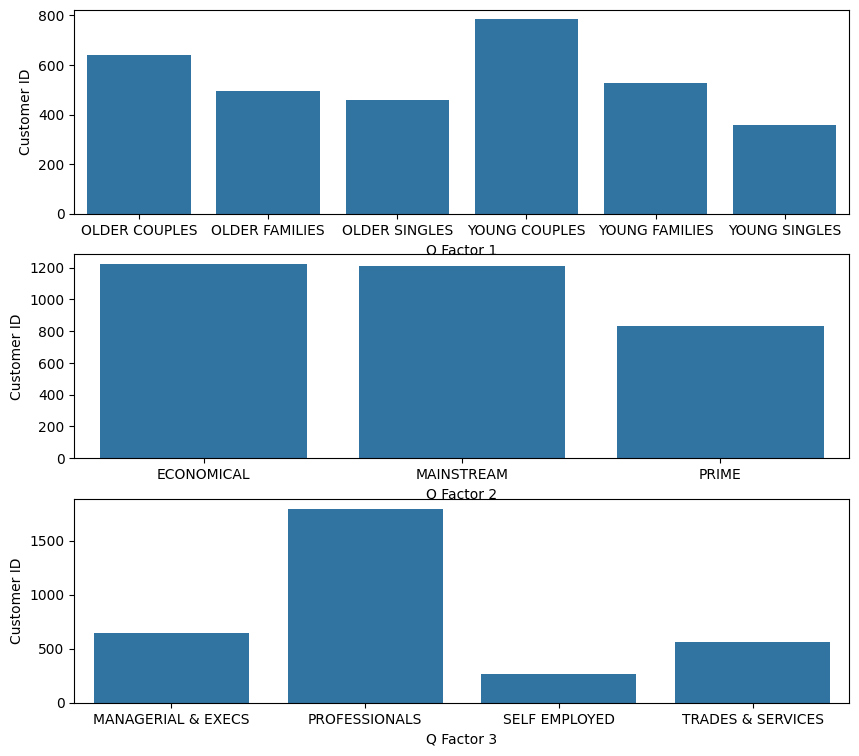

In [202]:
# Finding no. of applications put in by each Q factor
fig, ax = fa(3,1,(10,9))
for i in range(3):
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Customer ID'].count(), ax = ax[i])

<Axes: xlabel='Annual Income', ylabel='Cumulative Frequency Proportion'>

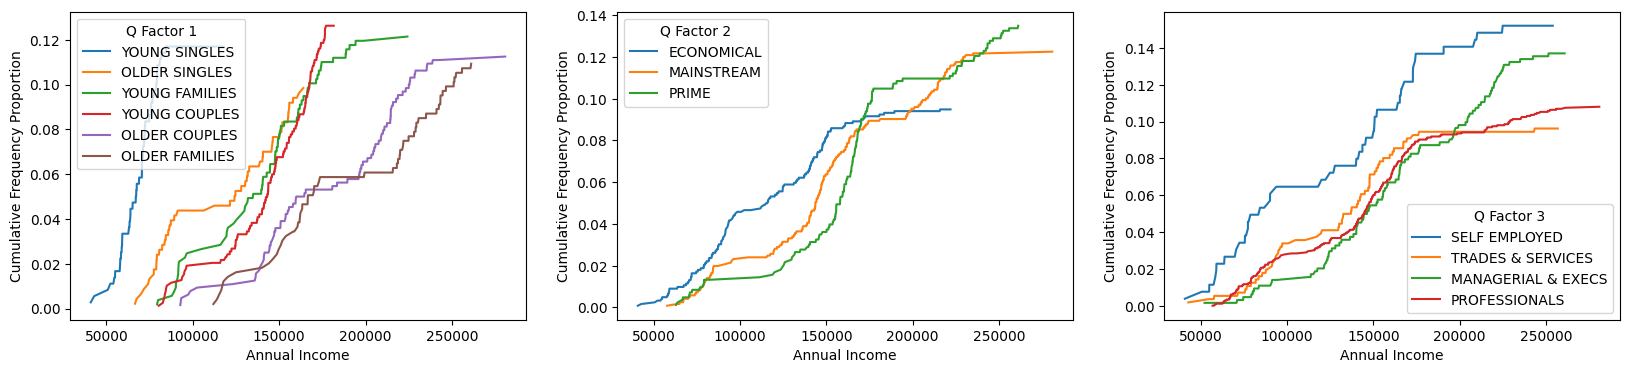

In [251]:
#looking at the effect of annual income to clawback frequency across different Q factors, standardising for loan count
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Annual Income', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Annual Income')
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency Proportion'].astype('float64')
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Annual Income', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])
fig

<Axes: xlabel='Interest Rate (p.a.)', ylabel='Cumulative Frequency Proportion'>

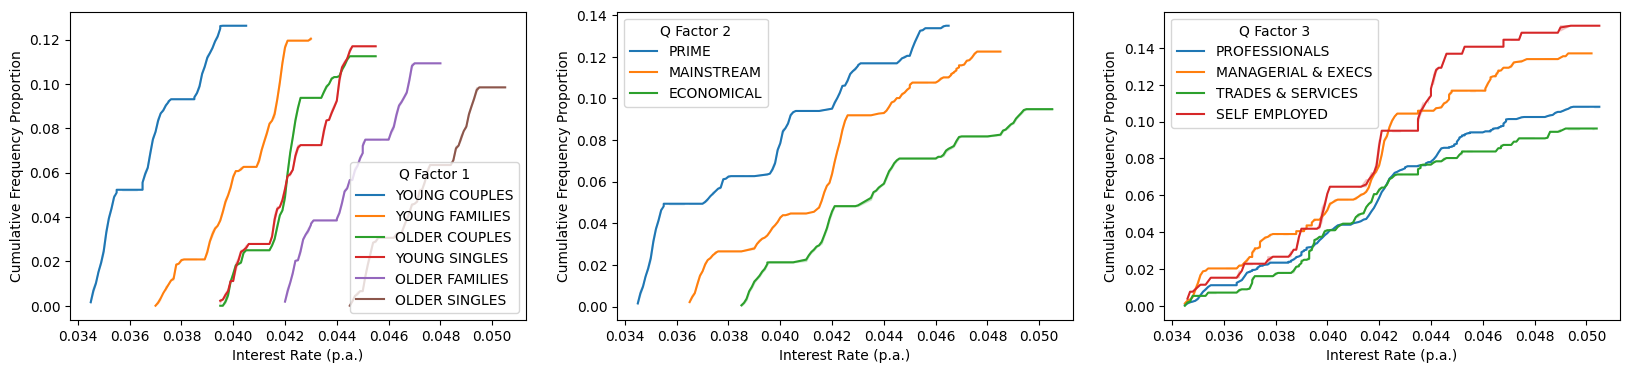

In [255]:
#looking at the effect of interest rate to clawback frequency across different Q factors
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Interest Rate (p.a.)', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Interest Rate (p.a.)')
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum().astype('float64')
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Interest Rate (p.a.)', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])
fig

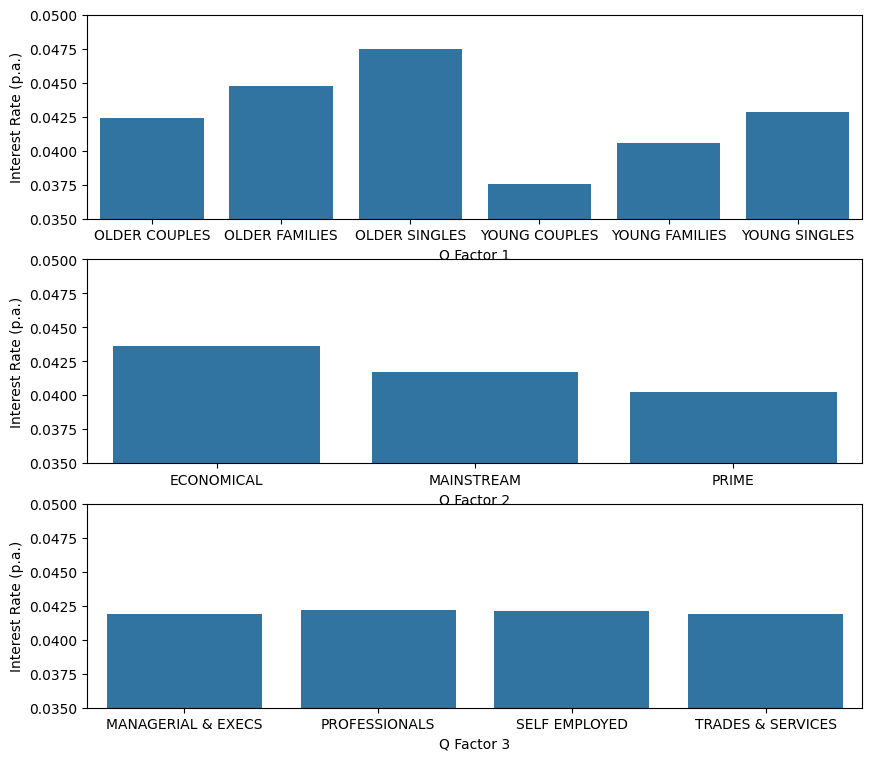

In [262]:
# Finding average interest rate per Q factors
fig, ax = fa(3,1,(10,9))
for i in range(3):
    ax[i].set_ylim(0.035,0.05)
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Interest Rate (p.a.)'].mean(), ax = ax[i])

## ANALYSIS:
Q FACTOR 1:
- Young couples have higher clawback counts but take much larger loan amounts despite being the group with 4th highest average annual income, they are also the group with most applications. possibly why they fail on repayments more
    - Young couples had lower average interest rates than their counterparts 
- After standardising for application count, the plot suggests young singles have higher clawback counts for smaller loan amounts, possibly due to only having a single income 
(as compared to an income of two, or a more matured and bigger income an older single may have)
    - Young singles are the riskiest.
- Young families seem to have low clawback counts compared to their counterparts (excluding young couples) for the same range of loan amounts

Q Factor 2:
- Economical have the lowest clawback counts compared to its counterparts for all ranges of loan amounts
- Economical had the highest average loan amount and lowest annual income, but still had lower counts of clawbacks than their counterparts, suggesting they are a better group to target
    - Lower proportional frequency for any given interest rate as well
- Prime had a marginally higher clawback cumulative frequency in proportion to the number of loans they apply for, even though they had the lowest loan counts, highest annual income and lowest loan amount average. This suggests they are the the riskiest of the three
    - Prime customers were the riskiest for any given interest rate, as they had the highest clawback counts


Q Factor 3:
- Although Professionals have higher clawback counts, this may be influenced by the large no. of loans they apply for in comparison with their counterparts (more than 3x the amount of loans self employed applied for).
- After standardising for loan counts, customers in the professional and trades and services had proportionally fewer clawbacks whereas self employed and managerial & execs had the highest counts 


<Axes: xlabel='Loan Amount', ylabel='Density'>

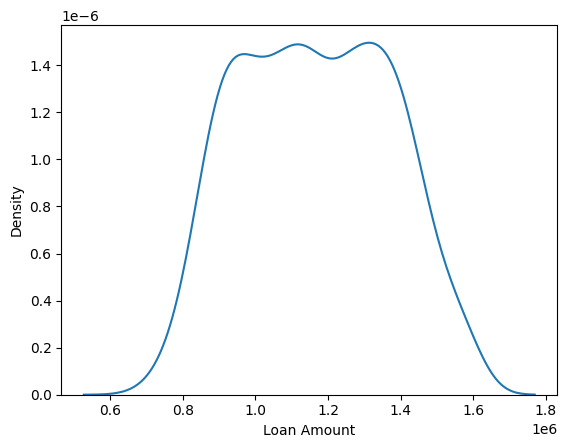

In [164]:
young_couples_loan_size = df[df['Q Factor 1'] == 'YOUNG COUPLES']['Loan Amount']
sns.kdeplot(young_couples_loan_size)

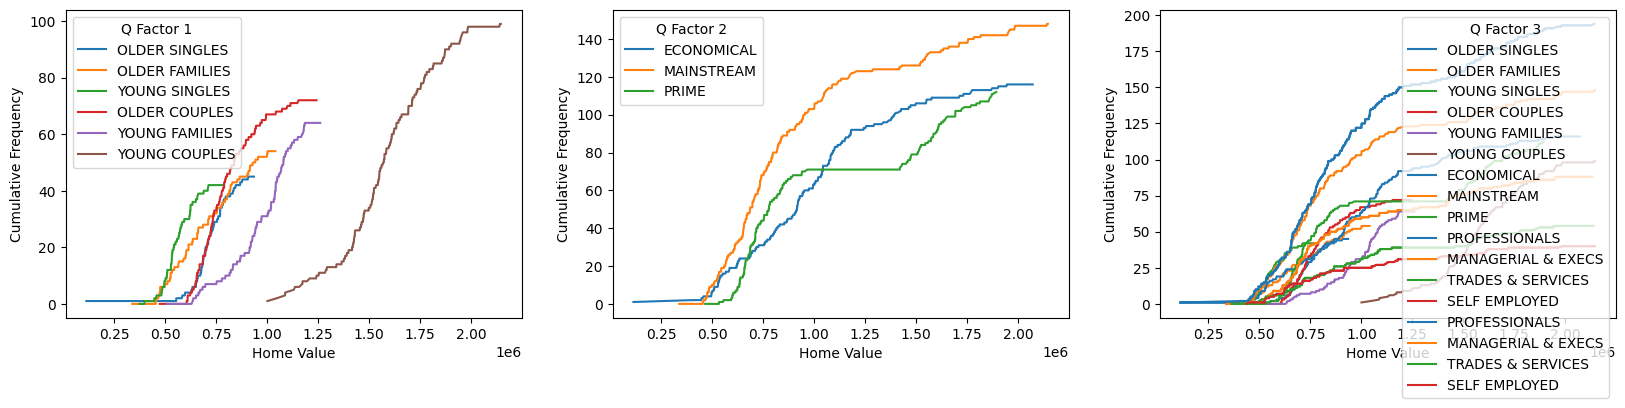

In [171]:
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_graph('Home Value', f'Q Factor {i+1}', ax=ax[i])
    

### investigating campaign and loan amounts effect on clawback frequency (while standardising for loan counts)

In [263]:
df['Campaign Name'].unique()

array(['Own marketing', 'TV campaign - instant approvals',
       'RiskyLending special'], dtype=object)

Text(0.5, 1.0, '*While standardising for Loan counts*')

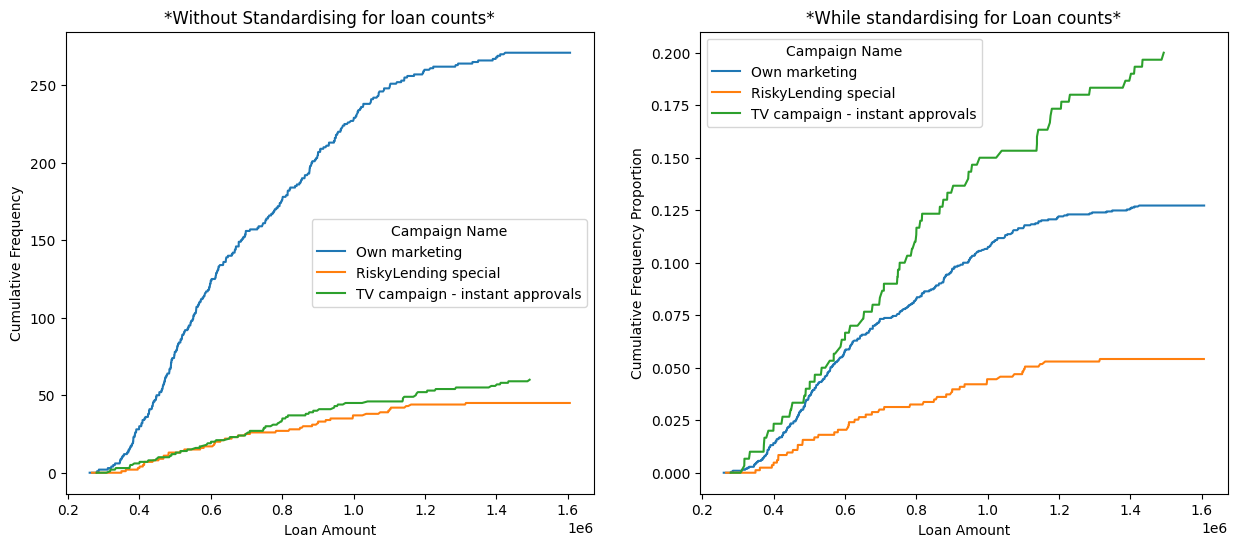

In [305]:
fig, ax = fa(1,2, (15,6))
cumfreq_df = df[['Loan Amount', 'Clawbacked', 'Campaign Name']].sort_values('Loan Amount')
cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum()
sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency', hue='Campaign Name', ax = ax[0])
ax[0].set_title('*Without Standardising for loan counts*')

counts_df = df.groupby('Campaign Name')['Customer ID'].count()
cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum().astype('float64')
for factor in counts_df.index:
    cumfreq_df.loc[cumfreq_df['Campaign Name'] == factor, 'Cumulative Frequency Proportion'] /= counts_df[factor]
sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency Proportion', hue='Campaign Name', ax = ax[1])
ax[1].set_title('*While standardising for Loan counts*')

In [283]:
# No. of customers from each campaign
counts_df

Campaign Name
Own marketing                      2130
RiskyLending special                831
TV campaign - instant approvals     300
Name: Customer ID, dtype: int64

In [286]:
df.groupby('Campaign Name')['Clawbacked'].sum()

Campaign Name
Own marketing                      271
RiskyLending special                45
TV campaign - instant approvals     60
Name: Clawbacked, dtype: int32

In [303]:
cumfreq_df = df[['Loan Amount', 'Clawbacked', 'Campaign Name']].sort_values('Loan Amount')
cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum().astype('float64')
cumfreq_df.loc[cumfreq_df['Campaign Name'] == 'TV campaign - instant approvals'].tail()

cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum().astype('float64')

#print(cumfreq_df.loc[cumfreq_df['Campaign Name'] == 'TV campaign - instant approvals', 'Cumulative Frequency Proportion'])
# for factor in counts_df.index:
#     print(factor, counts_df[factor])
#     cumfreq_df.loc[cumfreq_df['Campaign Name'] == factor, 'Cumulative Frequency Proportion'] /= counts_df[factor]
cumfreq_df.loc[cumfreq_df['Campaign Name'] == 'TV campaign - instant approvals'].tail()

,Loan Amount,Clawbacked,Campaign Name,Cumulative Frequency,Cumulative Frequency Proportion
1281,1473848.32,0,TV campaign - instant approvals,59.0,59.0
1362,1484280.00,0,TV campaign - instant approvals,59.0,59.0
901,1484994.00,0,TV campaign - instant approvals,59.0,59.0
1505,1487171.34,0,TV campaign - instant approvals,59.0,59.0
1430,1493238.74,1,TV campaign - instant approvals,60.0,60.0


# Analysis
- Although own marketing has highest clawback counts, might be due to the large no. of application counts
- In proportion to no. of application counts, we see that the TV - Special is the riskiest as they have the highest no. of clawbacks proportionally

## Next steps:
- Look at impact of home value for differing Q factors
- Look at Clawback delay for differing Q factors
- Look at relationship between clawback delay and interest rate
- Clawback delay and Q factor
- Campaign and Clawback frequency
- Campaign and clawback delay